In [218]:
import matplotlib.pyplot as plt
import cv2 
import pytesseract
from PIL import Image
from reportlab.lib.pagesizes import A4, letter
# Adding custom options

custom_config = r'--oem 2 --psm 12 -l fra'



In [219]:
A4_int = (int(round(A4[0])), int(round(A4[1])))

In [220]:
img = cv2.imread('img/test1.jpg',cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (A4_int[0],A4_int[1]) ,interpolation=cv2.INTER_CUBIC)
# img = cv2.resize(img, None,fx=2,fy=2 ,interpolation=cv2.INTER_CUBIC)

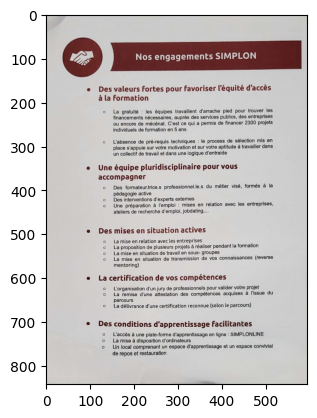

In [221]:
plt.imshow(img)

In [222]:
# cv2.imshow('image',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [223]:
# test = pytesseract.image_to_string(Image.fromarray(img), config=custom_config)
# test

In [224]:
# Perform OCR on the RGB image using pytesseract
text = pytesseract.image_to_data(Image.fromarray(img),output_type='dict',config=custom_config)

In [225]:
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i])
    #Draw box        
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

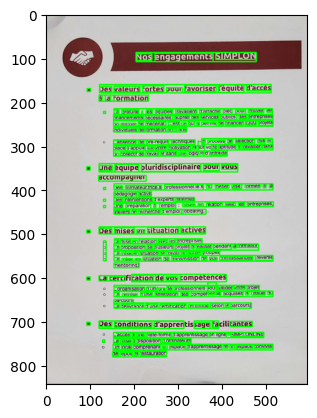

In [226]:
plt.imshow(img)

In [227]:
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    print(x, y, w, h,chara)

0 0 595 842 
204 87 273 21 
204 87 273 21 
204 87 273 21 
204 90 36 15 Nos
247 89 132 19 engagements
385 87 92 16 SIMPLON
93 169 8 7 
93 169 8 7 
93 169 8 7 
93 169 8 7 °
121 160 390 19 
121 160 390 19 
121 160 390 19 
121 165 28 12 Des
154 164 59 13 valeurs
219 163 48 14 fortes
273 167 36 12 pour
314 162 72 14 favoriser
391 161 58 17 l'équité
455 160 56 14 d'accès
120 184 112 14 
120 184 112 14 
120 184 112 14 
120 184 7 14 à
134 184 12 14 la
153 184 79 14 formation
130 221 5 5 
130 221 5 5 
130 221 5 5 
130 221 5 5 °
154 215 360 14 
154 215 360 14 
154 215 360 14 
154 218 11 9 La
172 218 38 11 gratuité
217 220 2 7 :
227 218 14 9 les
248 218 39 11 équipes
294 217 48 9 travaillent
348 216 47 9 d'arrache
402 216 20 11 pled
430 218 23 9 pour
459 216 35 8 trouver
501 215 13 8 les
153 228 362 13 
153 228 362 13 
153 228 362 13 
153 232 68 8 financements
225 231 62 10 nécessaires,
292 231 33 10 auprès
330 231 17 8 des
351 230 41 9 services
396 229 37 11 publics,
438 229 17 9 des
459 228 56 

In [228]:
from reportlab.pdfgen import canvas

def hello(c,left,top,text):
    c.drawString(left,top,text)
c = canvas.Canvas("hello.pdf")
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i],A4[1] - text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    hello(c,x,y,chara)
c.showPage()
c.save()